#### Loading the Libraires

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

#### Loading the Data

In [35]:
salary_df = pd.read_csv('salary.csv')

In [36]:
salary_df.head(5)

,YearsExperience,Salary
0,1.1,39343
1,1.3,46205
2,1.5,37731
3,2.0,43525
4,2.2,39891


#### Data Cleaning

In [37]:
salary_df.isnull().sum()

YearsExperience    0
Salary             0
dtype: int64

#### EDA

In [38]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsExperience  35 non-null     float64
 1   Salary           35 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 688.0 bytes


In [39]:
salary_df.describe()

,YearsExperience,Salary
count,35.000000,35.000000
mean,6.308571,83945.600000
std,3.618610,32162.673003
min,1.100000,37731.000000
25%,3.450000,57019.000000
50%,5.300000,81363.000000
75%,9.250000,113223.500000
max,13.500000,139465.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd02577fd0>,
      dtype=object)

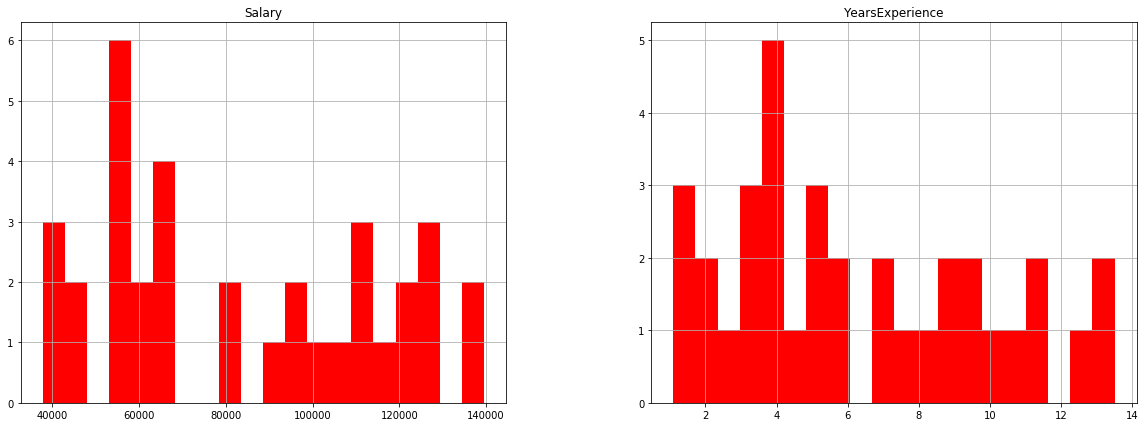

In [40]:
salary_df.hist(bins=20, figsize = (20,7), color = 'r')

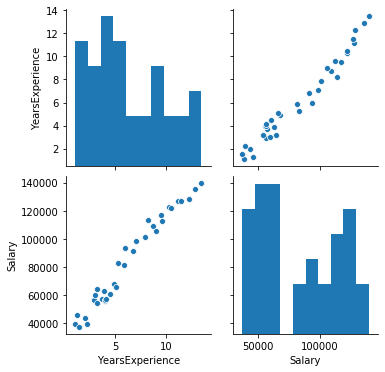

In [41]:
sns.pairplot(salary_df)

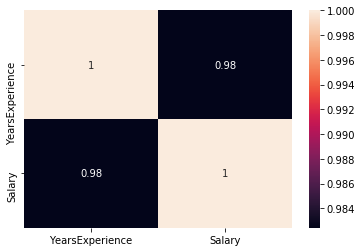

In [42]:
corr_matrix = salary_df.corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

In [43]:
max_years = salary_df.YearsExperience.max()

for i in range(len(salary_df)):
    if salary_df.YearsExperience[i] == max_years:
        print("Salary of most experienced employee: ",salary_df.Salary[i])

Salary of most experienced employee:  139465


In [44]:
min_years = salary_df.YearsExperience.min()

for i in range(len(salary_df)):
    if salary_df.YearsExperience[i] == min_years:
        print("Salary of most experienced employee: ",salary_df.Salary[i])

Salary of most experienced employee:  39343


#### Preparing Data for Training

In [45]:
X = salary_df.drop(['Salary'],axis=1)
Y = salary_df[['Salary']]

X = np.array(X).astype('float32')
Y = np.array(Y).astype('float32')

In [46]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [47]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(28, 1)
(28, 1)
(7, 1)
(7, 1)


In [48]:
x_train.shape

(28, 1)

In [49]:
y_train = y_train[:,0]

In [50]:
y_train.shape

(28,)

In [51]:
x_test.shape

(7, 1)

In [52]:
y_test = y_test[:,0]

In [53]:
y_test.shape

(7,)

#### Amazon Sagemaker

In [55]:
# Boto3 is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python
# Boto3 allows Python developer to write software that makes use of services like Amazon S3 and Amazon EC2

import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri

# Let's create a Sagemaker session
sagemaker_session = sagemaker.Session()

# Let's define the S3 bucket and prefix that we want to use in this session
bucket = 'sagemaker-studio-166845263086-nj50w9nc038'
prefix = 'linear_learner' # prefix is the subfolder within the bucket.

# Let's get the execution role for the notebook instance. 
# This is the IAM role that you created when you created your notebook instance. You pass the role to the training job.
# Note that AWS Identity and Access Management (IAM) role that Amazon SageMaker can assume to perform tasks on your behalf (for example, reading training results, called model artifacts, from the S3 bucket and writing training results to Amazon S3).
role = sagemaker.get_execution_role()
print(role)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210421T142169 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


arn:aws:iam::166845263086:role/service-role/AmazonSageMaker-ExecutionRole-20210421T142169


In [56]:
import io # The io module allows for dealing with various types of I/O (text I/O, binary I/O and raw I/O). 
import numpy as np
import sagemaker.amazon.common as smac # sagemaker common libary

# Code below converts the data in numpy array format to RecordIO format
# This is the format required by Sagemaker Linear Learner

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, x_train, y_train)
buf.seek(0) 
# When you write to in-memory byte arrays, it increments 1 every time you write to it
# Let's reset that back to zero 

0

In [57]:
import os

# Code to upload RecordIO data to S3
# Key refers to the name of the file    
key = 'linear-train-data'

# The following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-studio-166845263086-nj50w9nc038/linear_learner/train/linear-train-data


In [59]:
# Code to upload RecordIO data to S3

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, x_test, y_test)
buf.seek(0) 
# When you write to in-memory byte arrays, it increments 1 every time you write to it
# Let's reset that back to zero 

# Key refers to the name of the file    
key = 'linear-test-data'

# The following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)

# Let's print out the testing data location in s3
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_test_data))

# create an output placeholder in S3 bucket to store the linear learner output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

uploaded training data location: s3://sagemaker-studio-166845263086-nj50w9nc038/linear_learner/test/linear-test-data
Training artifacts will be uploaded to: s3://sagemaker-studio-166845263086-nj50w9nc038/linear_learner/output


In [60]:
# This code is used to get the training container of sagemaker built-in algorithms
# all we have to do is to specify the name of the algorithm, that we want to use

# Let's obtain a reference to the linearLearner container image
# Note that all regression models are named estimators
# You don't have to specify (hardcode) the region, get_image_uri will get the current region name using boto3.Session
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [61]:
# We have pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 
# We can also specify how many instances we would like to use for training

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count = 1, 
                                       train_instance_type = 'ml.m5.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session,
                                       train_use_spot_instances = True,
                                       train_max_run = 300,
                                       train_max_wait = 600)


# We can tune parameters like the number of features that we are passing in, type of predictor like 'regressor' or 'classifier', mini batch size, epochs
# Train 32 different versions of the model and will get the best out of them (built-in parameters optimization!)

linear.set_hyperparameters(feature_dim = 1,
                           predictor_type = 'regressor',
                           mini_batch_size = 5,
                           epochs = 5,
                           num_models = 32,
                           loss = 'absolute_loss')

# Now we are ready to pass in the training data from S3 to train the linear learner model

linear.fit({'train': s3_train_data})

# Let's see the progress using cloudwatch logs

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2021-04-21 10:01:34 Starting - Starting the training job...
2021-04-21 10:01:35 Starting - Launching requested ML instancesProfilerReport-1618999294: InProgress
...
2021-04-21 10:02:20 Starting - Insufficient capacity error from EC2 while launching instances, retrying!...
2021-04-21 10:03:02 Starting - Preparing the instances for training.........
2021-04-21 10:04:29 Downloading - Downloading input data...
2021-04-21 10:04:56 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/21/2021 10:05:01 INFO 140109431228224] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibr

#### Deploy and test the model 

In [62]:
# Deploying the model to perform inference 

linear_regressor = linear.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

---------------!

In [63]:
from sagemaker.predictor import csv_serializer, json_deserializer

# Content type overrides the data that will be passed to the deployed model, since the deployed model expects data in text/csv format.

# Serializer accepts a single argument, the input data, and returns a sequence of bytes in the specified content type

# Deserializer accepts two arguments, the result data and the response content type, and return a sequence of bytes in the specified content type.

# Reference: https://sagemaker.readthedocs.io/en/stable/predictors.html

sagemaker.serializers.CSVSerializer(content_type='text/csv')
linear_regressor.serializer = csv_serializer
linear_regressor.deserializer = json_deserializer

In [64]:
# making prediction on the test data

result = linear_regressor.predict(x_test)

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [65]:
result # results are in Json format

{'predictions': [{'score': 110691.4296875},
  {'score': 54062.25390625},
  {'score': 102301.921875},
  {'score': 85522.90625},
  {'score': 62451.76171875},
  {'score': 121178.3125},
  {'score': 73987.3359375}]}

In [66]:
# Since the result is in json format, we access the scores by iterating through the scores in the predictions

predictions = np.array([r['score'] for r in result['predictions']])

print(predictions)

[110691.4296875   54062.25390625 102301.921875    85522.90625
  62451.76171875 121178.3125      73987.3359375 ]


Text(0.5, 1.0, 'Salary vs. Years of Experience')

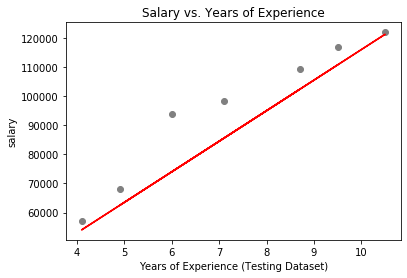

In [68]:
# VISUALIZE TEST SET RESULTS
plt.scatter(x_test, y_test, color = 'gray')
plt.plot(x_test, predictions, color = 'red')
plt.xlabel('Years of Experience (Testing Dataset)')
plt.ylabel('salary')
plt.title('Salary vs. Years of Experience')

In [70]:
# Delete the end-point

linear_regressor.delete_endpoint()

ClientError: An error occurred (ValidationException) when calling the DeleteEndpointConfig operation: Could not find endpoint configuration "arn:aws:sagemaker:ap-south-1:166845263086:endpoint-config/linear-learner-2021-04-21-10-05-53-786".